Make sure you download the 2016 Household LSMS survey data for Malawi, Ethiopia, and Nigeria from https://microdata.worldbank.org/index.php/catalog/lsms and put it in `../data/countries/`. Malawi's data should be named `malawi_2016/LSMS`, Ethiopia's should be named `ethiopia_2015/LSMS`, and Nigeria's should be named `nigeria_2015/LSMS`. Nightlights data should be downloaded from https://ngdc.noaa.gov/eog/viirs/download_dnb_composites.html using the annual composite from 2015 in tile 2 and tile 5.

In [29]:
import pandas as pd
import numpy as np
import os
import geoio
import matplotlib.pyplot as plt

%matplotlib inline

In [30]:
BASE_DIR = '..'

COUNTRIES_DIR = os.path.join(BASE_DIR, 'data', 'countries')
OLD_TIFF_DIR = [os.path.join(BASE_DIR, '../predicting-poverty-ethiopia/data/temp_geotiff/wc2.1_2.5m_tmax_1970-08.tif')]
NEW_TIFF_DIR = [os.path.join(BASE_DIR, '../predicting-poverty-ethiopia/data/temp_geotiff/wc2.1_2.5m_tmax_2015-08.tif')]

In [31]:
import sys
sys.path.append(BASE_DIR)
from utils import create_space

In [32]:
'''
The goal of each of these functions is to output a dataframe with the following columns:
country, cluster_lat, cluster_lon, cons_pc

Each row should represent one cluster by combining the household data
'''

def process_ethiopia():
    lsms_dir = os.path.join(COUNTRIES_DIR, 'ethiopia_2015', 'LSMS')
    consumption_file = 'Consumption Aggregate/cons_agg_w3.csv'
    consumption_pc_col = 'total_cons_ann' # per capita
    hhsize_col = 'hh_size' # people in household
    
    geovariables_file = 'Geovariables/ETH_HouseholdGeovars_y3.csv'
    lat_col = 'lat_dd_mod'
    lon_col = 'lon_dd_mod'

    # purchasing power parity for ethiopia in 2015 (https://data.worldbank.org/indicator/PA.NUS.PRVT.PP?locations=ET)
    ppp = 7.882
    
    for file in [consumption_file, geovariables_file]:
        assert os.path.isfile(os.path.join(lsms_dir, file)), print(f'Could not find {file}')
    
    df_c = pd.read_csv(os.path.join(lsms_dir, consumption_file))
    df_c['cons_ph'] = df_c[consumption_pc_col] * df_c[hhsize_col]
    df_c['pph'] = df_c[hhsize_col]
    df_c['cons_ph'] = df_c['cons_ph'] / ppp / 365
    df = df_c[['household_id2', 'cons_ph', 'pph']]
    
    df_geo = pd.read_csv(os.path.join(lsms_dir, geovariables_file))
    df_cords = df_geo[['household_id2', lat_col, lon_col]]
    df_cords.rename(columns={lat_col: 'cluster_lat', lon_col: 'cluster_lon'}, inplace=True)
    df_combined = pd.merge(df, df_cords, on='household_id2')
    df_combined.drop(['household_id2'], axis=1, inplace=True)
    df_combined.dropna(inplace=True) # can't use na values
    
    df_clusters = df_combined.groupby(['cluster_lat', 'cluster_lon']).sum().reset_index()
    df_clusters['cons_pc'] = df_clusters['cons_ph'] / df_clusters['pph'] # divides total cluster income by people
    #df_clusters['total_hv'] = df_clusters['total_hv']
    df_clusters['country'] = 'eth'
    return df_clusters[['country', 'cluster_lat', 'cluster_lon', 'cons_pc']]

In [33]:
df_eth = process_ethiopia()

/root/miniconda3/envs/omtest/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [34]:
df_eth.shape

(523, 4)

In [35]:
df_eth.head()

,country,cluster_lat,cluster_lon,cons_pc
0,eth,3.455701,39.515994,14.854634
1,eth,3.549937,39.184234,14.312022
2,eth,3.864243,39.101366,12.470145
3,eth,3.982931,38.491368,8.336539
4,eth,4.048194,41.930928,4.762526


In [36]:
old_tifs = [geoio.GeoImage(ndir) for ndir in OLD_TIFF_DIR]
new_tifs = [geoio.GeoImage(ndir) for ndir in NEW_TIFF_DIR]

In [37]:
old_tif_array = np.squeeze(old_tifs[0].get_data())
new_tif_array = np.squeeze(new_tifs[0].get_data())

In [38]:
new_tif_array.shape

(4320, 8640)

In [39]:
#tif, tif_array = old tif
def add_temps(df, tif, new_tif, tif_array, new_tif_array):
    ''' 
    This takes a dataframe with columns cluster_lat, cluster_lon and finds the average 
    nightlights in 2015 using a 10kmx10km box around the point
    
    I try all the nighlights tifs until a match is found, or none are left upon which an error is raised
    '''
    cluster_temps = []
    for i,r in df.iterrows():
        min_lat, min_lon, max_lat, max_lon = create_space(r.cluster_lat, r.cluster_lon)
        
        xminPixel, ymaxPixel = tif.proj_to_raster(min_lon, min_lat)
        xmaxPixel, yminPixel = tif.proj_to_raster(max_lon, max_lat)
        assert xminPixel < xmaxPixel, print(r.cluster_lat, r.cluster_lon)
        assert yminPixel < ymaxPixel, print(r.cluster_lat, r.cluster_lon)
        if xminPixel < 0 or xmaxPixel >= tif_array.shape[1]:
            print(f"no match for {r.cluster_lat}, {r.cluster_lon}")
            raise ValueError()
        elif yminPixel < 0 or ymaxPixel >= tif_array.shape[0]:
            print(f"no match for {r.cluster_lat}, {r.cluster_lon}")
            raise ValueError()
        xminPixel, yminPixel, xmaxPixel, ymaxPixel = int(xminPixel), int(yminPixel), int(xmaxPixel), int(ymaxPixel)
        cluster_temps.append(tif_array[yminPixel:ymaxPixel,xminPixel:xmaxPixel].mean())
    
    new_cluster_temps = []
    for i,r in df.iterrows():
        min_lat, min_lon, max_lat, max_lon = create_space(r.cluster_lat, r.cluster_lon)
        
        xminPixel, ymaxPixel = new_tif.proj_to_raster(min_lon, min_lat)
        xmaxPixel, yminPixel = new_tif.proj_to_raster(max_lon, max_lat)
        assert xminPixel < xmaxPixel, print(r.cluster_lat, r.cluster_lon)
        assert yminPixel < ymaxPixel, print(r.cluster_lat, r.cluster_lon)
        if xminPixel < 0 or xmaxPixel >= new_tif_array.shape[1]:
            print(f"no match for {r.cluster_lat}, {r.cluster_lon}")
            raise ValueError()
        elif yminPixel < 0 or ymaxPixel >= new_tif_array.shape[0]:
            print(f"no match for {r.cluster_lat}, {r.cluster_lon}")
            raise ValueError()
        xminPixel, yminPixel, xmaxPixel, ymaxPixel = int(xminPixel), int(yminPixel), int(xmaxPixel), int(ymaxPixel)
        new_cluster_temps.append(new_tif_array[yminPixel:ymaxPixel,xminPixel:xmaxPixel].mean())
        
    array1 = np.array(new_cluster_temps)
    array2 = np.array(cluster_temps)
    subtracted_array = np.subtract(array1, array2)
    delta_temps = list(subtracted_array)
    df['temp'] = delta_temps

In [40]:
add_temps(df_eth, old_tifs[0], new_tifs[0], old_tif_array, new_tif_array)

In [41]:
df_eth.corr()

,cluster_lat,cluster_lon,cons_pc,temp
cluster_lat,1.000000,0.157130,-0.052673,-0.788717
cluster_lon,0.157130,1.000000,0.211846,0.022047
cons_pc,-0.052673,0.211846,1.000000,0.107919
temp,-0.788717,0.022047,0.107919,1.000000


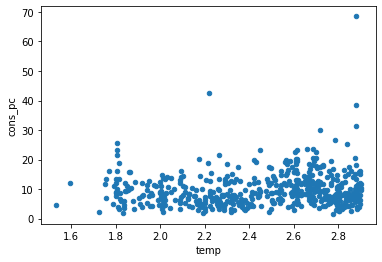

In [42]:
df_eth.plot.scatter(x="temp", y="cons_pc")
x = df_eth['temp']
y = df_eth['cons_pc']
# plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
# plt.plot(x, y)
# plt.xlim([0,])
# plt.ylim() 
plt.show()

In [45]:
for country in ['ethiopia_2015']:
    os.makedirs(os.path.join(COUNTRIES_DIR, country, 'processed'), exist_ok=True)

In [46]:
df_eth.to_csv(os.path.join(COUNTRIES_DIR, 'ethiopia_2015', 'processed/clusters.csv'), index=False)